In [41]:
import torch 
import torchvision
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 

In [109]:
image_size = 32
patch_size = 8
if image_size % patch_size != 0: 
    raise ValueError("Image size must be divisible by patch size. Got (32 and 8)")

image = torch.rand(10, image_size, image_size, 3) 


def patch_image(images, patch_size): 
    patches = []
    image_size = images.shape[-1]

    for row_idx in range(0, image_size, patch_size): 
        for col_idx in range(0, image_size, patch_size):
            patch = images[:, :, :, row_idx: row_idx + patch_size, col_idx: col_idx + patch_size]
            patches.append(patch)

    patches = torch.stack(patches, dim=-3) # (B, S+1, C, P**2, w, h)
    B, S, c, N, p, _ = patches.shape
    patches = patches.view(B, S, c, N, p*p)

    return patches

# print(len(patches))
# for i, patch in enumerate(patches): 
#     plt.imshow(patch[0])
#     plt.show()


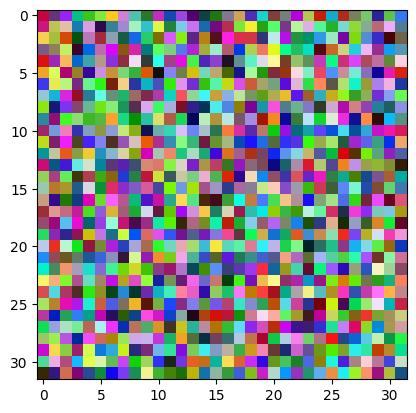

torch.Size([10, 5, 3, 32, 32])


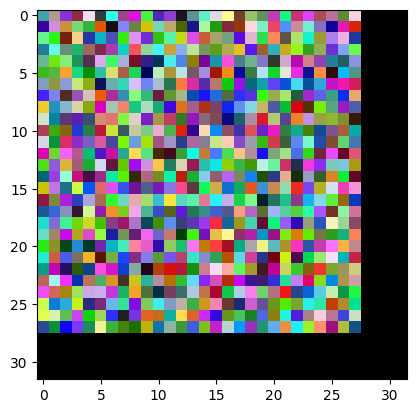

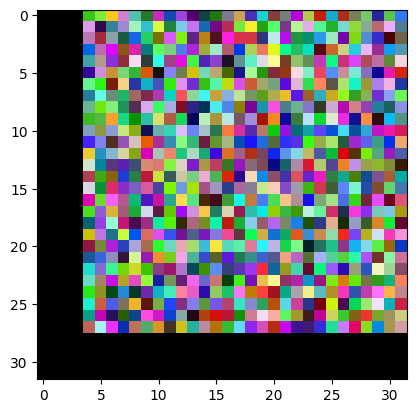

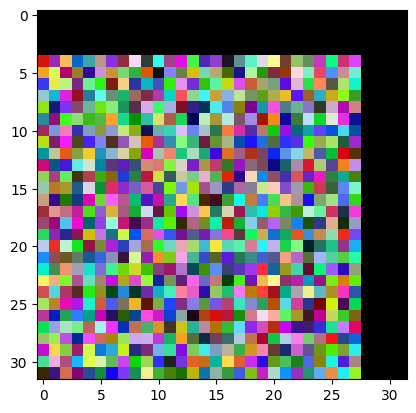

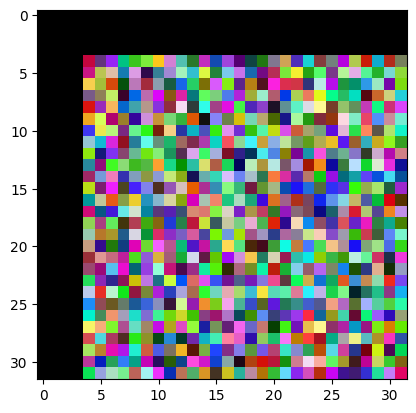

In [106]:
MODE = {
    "left-up" : {
        "crop_x" : patch_size // 2, 
        "crop_y" : patch_size // 2, 
        "pad" : (0, 0 , patch_size // 2, patch_size // 2)
    }, 
    "right-up" : {
        "crop_x" : 0, 
        "crop_y" : patch_size // 2, 
        "pad" : (patch_size // 2, 0, 0, patch_size // 2), 
    }, 
    "left-down" : {
        "crop_x" : patch_size // 2, 
        "crop_y" : 0, 
        "pad" : (0, patch_size // 2, patch_size // 2, 0), 
    }, 
    "right-down" : {
        "crop_x" : 0, 
        "crop_y" : 0, 
        "pad" : (patch_size // 2, patch_size // 2, 0, 0), 
    }, 
}


plt.imshow(image[0])
plt.show()

shifted = [image.permute(0, 3, 1, 2)]

for mode in MODE: 
    crop = torchvision.transforms.functional.crop(image.permute(0, 3, 1, 2), MODE[mode]["crop_x"], MODE[mode]["crop_y"], image_size - patch_size//2, image_size - patch_size//2) 
    pad = torchvision.transforms.functional.pad(crop, padding=MODE[mode]["pad"])
    shifted.append(pad)

shifted = torch.stack(shifted, dim=1)
print(shifted.shape)

for i in range(1, len(MODE)+1): 
    plt.imshow(shifted[0][i].permute(1, 2, 0))
    plt.show()


In [110]:
patch_image(shifted, 8).shape

before reshape :  torch.Size([10, 5, 3, 16, 8, 8])


torch.Size([10, 5, 3, 16, 64])